In [430]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.api as sm
import statsmodels.formula.api as smf
from textblob import TextBlob
import re
import json

DATASET LOADING

In [431]:
#Read the files
normal_reviews = pd.read_csv('outcomes/relevant_reviews.csv')  
not_recommended = pd.read_csv('outcomes/not-recommended-reviews.csv') 

In [432]:
print(f'The dataset contains {len(normal_reviews)} normal reviews and {len(not_recommended)} not recommended reviews')
print(f'there are {normal_reviews["business_id"].nunique()} unique businesses in the dataset')
print()  

print(f"First normal-review-date: {normal_reviews['date'].min()}")
print(f"Last normal-review-date: {normal_reviews['date'].max()}")

The dataset contains 82982 normal reviews and 9683 not recommended reviews
there are 505 unique businesses in the dataset

First normal-review-date: 2005-02-16 04:06:26
Last normal-review-date: 2022-01-19 18:05:57


SELECT CUTOFF AND TIMEDELTA

In [433]:
#select a cut_off date
cut_off_date = pd.to_datetime("2013-11-14")

#select time delta to define pre- post- periods 
weeks = 12
time_delta = pd.Timedelta(weeks=weeks)

start_date = cut_off_date - time_delta
end_date = cut_off_date + time_delta

DATA CLEANING

In [434]:
#Drop review id, 'useful', 'funny', 'cool. I dont think we need it.
normal_reviews = normal_reviews.drop(['useful','review_id', 'funny','cool'], axis=1)

In [435]:
#Fix the date format.
normal_reviews['date'] = pd.to_datetime(normal_reviews['date'])

not_recommended['review_date'] = not_recommended['review_date'].str.split('\n').str[0]
not_recommended['review_date'] = pd.to_datetime(not_recommended['review_date'], format='%d.%m.%Y', errors='coerce')

In [436]:
#Fix the textual content (should facilitate TextBlob)
def clean_text(text):
    text = text.lower()
    text = text.replace('\n', ' ')

    return text

# Apply cleaning function to the DataFrame
normal_reviews['text'] = normal_reviews['text'].apply(clean_text)

In [437]:
#Starting dataset normal reviews after cleaning
normal_reviews.head(5)

,user_id,business_id,stars,text,date
0,smOvOajNG0lS4Pq7d8g4JQ,RZtGWDLCAtuipwaZ-UfjmQ,4,good food--loved the gnocchi with marinara the...,2009-10-14 19:57:14
1,9oHOoqk-HlwDS2DlHLi_0g,TttFjRQ-8Iz8by4hsD7iOQ,5,last night we tried to get into the oldest ita...,2017-11-06 17:26:43
2,gSEhdaQNcewg-ob6xSgleQ,1NCUTTp6rIyXpwUDVv9qOA,2,i had to write an order after coming here a co...,2016-06-22 21:51:03
3,JW5W4OZCohTvZlRF1jzrTg,u7_3L1NBWgxhBM_B-cmmnA,4,this amazing brick oven pizza joint gets bette...,2017-04-30 15:00:27
4,7ktyPHE-NGnWxarOqjIQiQ,CinrOH8rMB2hEvPY_iFOHA,1,"i really wanted to like casselli's, but it was...",2009-03-02 02:05:49


In [438]:
#Starting dataset not-recommended reviews
not_recommended.head()

,business_id,user_name,user_location,has_image,friends_count,reviews_count,photos_count,rating,review_date,language,review_text
0,QdN72BWoyFypdGJhhI5r7g,C C.,"Philadelphia, Vereinigte Staaten",False,0,1,0,1.0 Sterne,2016-11-06,en,"Totally dissapionted and a big boo!, Maybe the..."
1,QdN72BWoyFypdGJhhI5r7g,Edward M.,"Philadelphia, Vereinigte Staaten",False,0,13,0,2.0 Sterne,2019-06-30,en,Pros: good food. Decent drinks. Nice neighborh...
2,QdN72BWoyFypdGJhhI5r7g,Isabel W.,"Mercer Island, Vereinigte Staaten",False,65,59,1 Foto,3.0 Sterne,2019-06-02,en,"Good, honey bar, but it hardly ever has dark b..."
3,QdN72BWoyFypdGJhhI5r7g,Katherine T.,"Camden County, Vereinigte Staaten",False,308,3,0,5.0 Sterne,2019-07-12,en,Phenomenal customer service. Jules is amazing....
4,QdN72BWoyFypdGJhhI5r7g,Jay M.,"Millstone, Vereinigte Staaten",True,187,2,0,5.0 Sterne,2017-02-09,en,"Great food, great service. Best happy hour aro..."


ANALYZING DATA PRE-TREATMENT

12 weeks pre-treat contains: 1655 normal revies and 228 not recommended reviews
q1 1.0 is q4 is 7.0


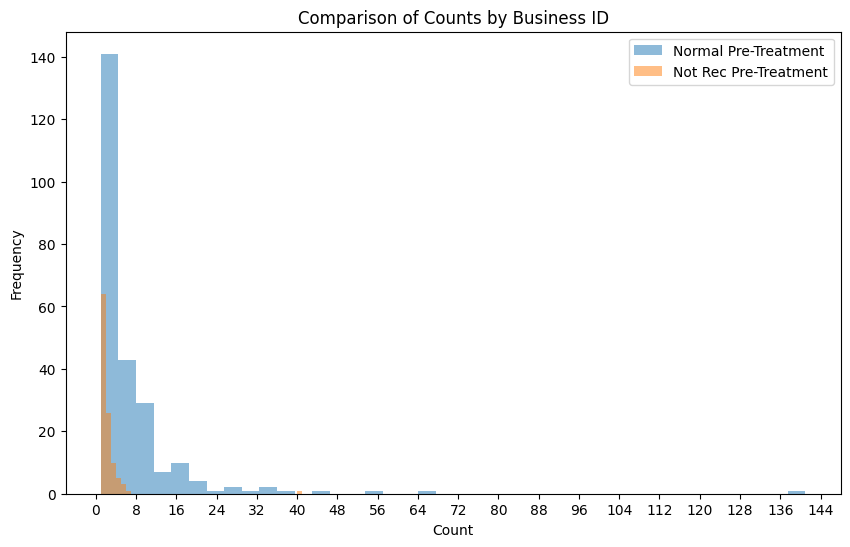

In [439]:
#check distribution of the not-recommended in pre-treatment  (q1-q4)

start_date_pre = cut_off_date - time_delta

#select only reviews in the time_delta range
#between start_data and cut_off_date
normal_pre_treat = normal_reviews[(normal_reviews['date'] >= start_date_pre) & (normal_reviews['date'] <= cut_off_date)]
not_rec_pre_treat = not_recommended[(not_recommended['review_date'] >= start_date_pre) & (not_recommended['review_date'] <= cut_off_date)]

print(f'12 weeks pre-treat contains: {len(normal_pre_treat)} normal revies and {len(not_rec_pre_treat)} not recommended reviews')

#group by business_id
group_pre_treatment_normal = normal_pre_treat.groupby(by='business_id').size().reset_index(name='count')
group_pre_treatment_not_rec = not_rec_pre_treat.groupby(by='business_id').size().reset_index(name='count')

#plot
plt.figure(figsize=(10, 6))

plt.hist(group_pre_treatment_normal['count'], bins=40, alpha=0.5, label='Normal Pre-Treatment')
plt.hist(group_pre_treatment_not_rec['count'], bins=40, alpha=0.5, label='Not Rec Pre-Treatment')

plt.title('Comparison of Counts by Business ID')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.legend()

ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=20)) 

q1 = group_pre_treatment_normal['count'].quantile(0.25)
q4 = group_pre_treatment_normal['count'].quantile(0.75)

print(f"q1 {q1} is q4 is {q4}")

PREPARING DATA FOR DIFFERENCE IN DIFFERENCE (WHOLE DATASET)

In [440]:
#DECIDE IF REVIEWS ARE DONE BEFORE OR AFTER CUT_OFF_DATE

#decide if the reviews are pre or post cut_off_date (0 pre - 1 post) (Change Dummy)
normal_reviews['cut_off_date'] = (normal_reviews['date'] >= cut_off_date).astype(int)
not_recommended['cut_off_date'] = (not_recommended['review_date'] >= cut_off_date).astype(int)

In [441]:
#DO NOT DELETE
#DO NOT DELETE
#DO NOT DELETE

# #COUNT amount of  normal PRE and POST change (whole dataset, not only -12 cut_off +12 cut_off)

# #Get total number of normal reviews PRE CUTOFF DATE --> #3316
# count_normal_reviews_pre = len(normal_reviews[normal_reviews['cut_off_date'] == 0])
# #Get total number of not recommended reviews POST CUTOFF DATE --> #6367
# count_normal_reviews_after = len(normal_reviews[normal_reviews['cut_off_date'] == 1])

# #Get total number of not recommended reviews PRE CUTOFF DATE --> #3316
# count_not_rec_reviews_pre = len(not_recommended[not_recommended['cut_off_date'] == 0])
# #Get total number of not recommended reviews POST CUTOFF DATE --> #6367
# count_not_rec_reviews_after = len(not_recommended[not_recommended['cut_off_date'] == 1])


# print(f"Total normal reviews {count_normal_reviews_pre + count_normal_reviews_after} (whole dataset)")
# print(f"Total normal reviews PRE CUTOFF DATE: {count_normal_reviews_pre}, POST CUTOFF DATE: {count_normal_reviews_after}")

# print(f"Total not recommended reviews {count_not_rec_reviews_after + count_not_rec_reviews_pre} (whole dataset)")
# print(f"Total not recommended reviews PRE CUTOFF DATE: {count_not_rec_reviews_pre}, POST CUTOFF DATE: {count_not_rec_reviews_after}")

In [442]:
#CREATE TOTAL NUMBER OF NOT_RECOMMENDED_TILL_CUT_OFF_DATE

#Discard everything after cut_off_date
business_id_number_not_rec = not_recommended[not_recommended['cut_off_date'] == 0] 

#Group by business_id and count number of reviews before policy change
business_id_number_not_rec = business_id_number_not_rec.groupby('business_id').size().reset_index(name='not_recommended_review_count_pre') 

In [443]:
#ADD not_recommended_review_count_pre to the normal reviews

#Join this with every review in the normal-review-dataset
merged_data_updated = pd.merge(normal_reviews, business_id_number_not_rec, on='business_id', how='left')
#Fill 0 means the had no NOT-RECOMMENDED
merged_data_updated['not_recommended_review_count_pre'] = merged_data_updated['not_recommended_review_count_pre'].fillna(0)

merged_data_updated.head()

,user_id,business_id,stars,text,date,cut_off_date,not_recommended_review_count_pre
0,smOvOajNG0lS4Pq7d8g4JQ,RZtGWDLCAtuipwaZ-UfjmQ,4,good food--loved the gnocchi with marinara the...,2009-10-14 19:57:14,0,9.0
1,9oHOoqk-HlwDS2DlHLi_0g,TttFjRQ-8Iz8by4hsD7iOQ,5,last night we tried to get into the oldest ita...,2017-11-06 17:26:43,1,0.0
2,gSEhdaQNcewg-ob6xSgleQ,1NCUTTp6rIyXpwUDVv9qOA,2,i had to write an order after coming here a co...,2016-06-22 21:51:03,1,6.0
3,JW5W4OZCohTvZlRF1jzrTg,u7_3L1NBWgxhBM_B-cmmnA,4,this amazing brick oven pizza joint gets bette...,2017-04-30 15:00:27,1,4.0
4,7ktyPHE-NGnWxarOqjIQiQ,CinrOH8rMB2hEvPY_iFOHA,1,"i really wanted to like casselli's, but it was...",2009-03-02 02:05:49,0,2.0


In [444]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

q1_value = 10
q4_value = 30

In [445]:
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

#CONTROL OR TREATMENT? --> THIS ADJUST
#Focus on q1 (bottom 25% of number of not recommended) for control group and q4 (top 25% of number of not recommended) for treatment group

#line below only if we do quarite .33 .54 etc
#unique_restaurants_df = merged_data_updated.drop_duplicates(subset='business_id', keep='first')



#Remove those in q2 and q3
merged_data_updated = merged_data_updated[
    (merged_data_updated['not_recommended_review_count_pre'] <= q1_value) |
    (merged_data_updated['not_recommended_review_count_pre'] >= q4_value)
]

#ADD TREATMENT OR CONTROL BINARY

merged_data_updated['treatment'] = merged_data_updated['not_recommended_review_count_pre'].apply(
    lambda x: 0 if x <= q1_value else 1)

#4. how many restaurants?
control_group_count = merged_data_updated[merged_data_updated['treatment'] == 0]['business_id'].nunique()
treatment_group_count = merged_data_updated[merged_data_updated['treatment'] == 1]['business_id'].nunique()


#print(f"Control Group: {control_group_count} businesses, Treatment Group: {treatment_group_count} businesses")
#print(f"there are {len(merged_data_updated)} reviews")

In [446]:
#FILTER ONLY FOR +/- TIMEDELTA

#select only reviews in the time_delta range
filtered_data = merged_data_updated[(merged_data_updated['date'] >= start_date) & (merged_data_updated['date'] <= end_date)]

In [447]:
control_group_count = filtered_data[filtered_data['treatment'] == 0]['business_id'].nunique()
treatment_group_count = filtered_data[filtered_data['treatment'] == 1]['business_id'].nunique()

#print('After timedelta filtering')
print(f"Control Group: {control_group_count} businesses, Treatment Group: {treatment_group_count} businesses")

Control Group: 196 businesses, Treatment Group: 15 businesses


In [448]:
#ADD COLUMN FOR LENGTH OF TEXT-REVIEW
filtered_data['text_length'] = filtered_data['text'].apply(len)

/var/folders/_v/_hbrmw9n4qjdtrf9w3730x680000gn/T/ipykernel_84858/2498021550.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['text_length'] = filtered_data['text'].apply(len)


In [449]:
#ADD LOGIC FOR SENTIMENTAL ANALYSIS (package is texblob, rating from -1 to 1)
#This is also slow, no idea why.

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

filtered_data['sentiment_score'] = round(filtered_data['text'].apply(get_sentiment), 4)

/var/folders/_v/_hbrmw9n4qjdtrf9w3730x680000gn/T/ipykernel_84858/2721293727.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['sentiment_score'] = round(filtered_data['text'].apply(get_sentiment), 4)


In [450]:
filtered_data.head()

,user_id,business_id,stars,text,date,cut_off_date,not_recommended_review_count_pre,treatment,text_length,sentiment_score
28,Yr7tRi9b5-Na2FWP5ihG2A,BWITd9JUXP3gSi1z3Y-z8g,4,amazing pizza. also love ceci bean dip. great ...,2013-10-24 02:21:23,0,9.0,0,117,0.4333
33,X9jjZ93FFoVEo6lqy6CAGw,L2pmVQMrpY-yZwZkZoRt5g,1,over priced . every time i go there the owner ...,2013-10-03 17:03:48,0,1.0,0,414,-0.1788
63,aNdHTuVfgUFi7vMlVZ3J8Q,u7_3L1NBWgxhBM_B-cmmnA,4,we really enjoyed our visit to pizzeria vetri....,2014-01-17 18:20:23,1,4.0,0,420,0.3514
68,70SYLsz1p8K7dYU6koZ7Kg,1NCUTTp6rIyXpwUDVv9qOA,4,"tried the cheesesteak, italian hoagie and mozz...",2013-10-26 18:25:11,0,6.0,0,313,0.4857
69,3qkPmzCKpvyK_4z16uIVDA,BWITd9JUXP3gSi1z3Y-z8g,5,in riva never disappoints. the food is delicio...,2013-12-07 13:01:36,1,9.0,0,339,0.7100


In [451]:
#merged_data_updated['did_dummy'] = merged_data_updated['cut_off_date'] * merged_data_updated['treatment']
#merged_data_updated = merged_data_updated.rename('review_id')

desired_order = ['user_id', 'business_id', 'date', 'stars', 'text', 'cut_off_date', 'not_recommended_review_count_pre', 'treatment', 'text_length', 'sentiment_score',]
filtered_data = filtered_data[desired_order]

ANALYSIS OF THE DATA (GRAPHS)

In [452]:
#total number of normal reviews
print(f"Reviews in the {weeks * 2}-weeks window: {len(filtered_data)}")
print()

#total number of normal reviews pre
print(f"Reviews in the pre-treatment window: {len(filtered_data[filtered_data['treatment'] == 0])}")
print(f"Total Business in pre-treatment window: {filtered_data[filtered_data['treatment'] == 0]['business_id'].nunique()}")

print()

#total nubmer of normal reviews after
print(f"Reviews in the post-treatment window: {len(filtered_data[filtered_data['treatment'] == 1])}")
print(f"Total Business in post-treatment window: {filtered_data[filtered_data['treatment'] == 1]['business_id'].nunique()}")

print()
      
#print number of unique restaurants in the pre + post time window.
print(f'Unique restaurants in the 24 time window: {filtered_data["business_id"].nunique("business_id")}')


Reviews in the 24-weeks window: 2197

Reviews in the pre-treatment window: 1373
Total Business in pre-treatment window: 196

Reviews in the post-treatment window: 824
Total Business in post-treatment window: 15

Unique restaurants in the 24 time window: 211


In [453]:
#group by - business_id - 'treatmen' - 'pediod' and doing the means
review_counts_period = filtered_data.groupby(['business_id', 'treatment', 'cut_off_date']).agg(
    review_count=('business_id', 'size'), #smaller aggregation, maybe for each week,
).reset_index()

In [454]:
datasets = []
for treatment in (0, 1):
    for cut_off in (0, 1):  
        subset = review_counts_period[(review_counts_period['treatment'] == treatment) & (review_counts_period['cut_off_date'] == cut_off)]
        title = f"{'Treatment' if treatment else 'Control'} - {'After' if cut_off else 'Before'}"
        datasets.append((subset, title))

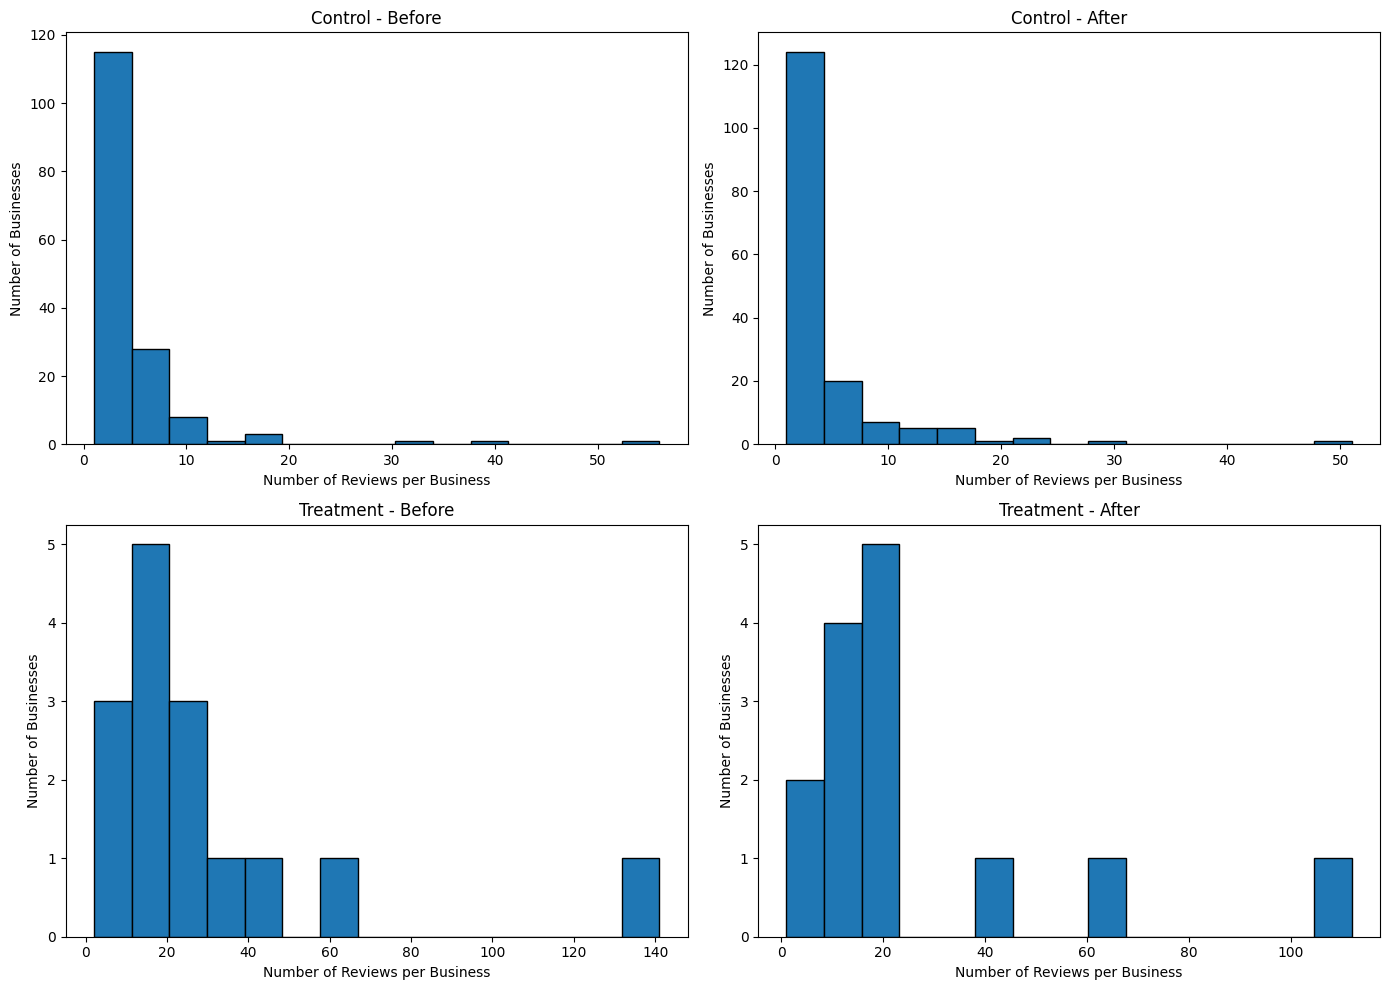

In [455]:
#plot the graphs
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for idx, (data, title) in enumerate(datasets):
    if 'review_count' in data.columns:
        axs[idx].hist(data['review_count'], bins= 15, edgecolor='black')
        # Optionally, set specific locator settings here if needed
        # axs[idx].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        axs[idx].set_title(title)
        axs[idx].set_xlabel('Number of Reviews per Business')
        axs[idx].set_ylabel('Number of Businesses')
    else:
        axs[idx].text(0.5, 0.5, 'No review_count data available', ha='center', va='center')
        axs[idx].set_title(title)

plt.tight_layout()
plt.show()

In [456]:
len(filtered_data)

2197

STAT-ANALYSIS OF THE DATA (DIVIDED IN TREATMENT - CONTROL X PRE - POST)

In [457]:
statistics = {}  # Dictionary to store statistics for each subset

for treatment in (0, 1):
    for cut_off in (0, 1):
        subset = filtered_data[(filtered_data['treatment'] == treatment) & (filtered_data['cut_off_date'] == cut_off)]
        
        # Dictionary to hold statistics for the current subset
        subset_stats = {}
        
        # List of columns to calculate statistics for
        columns_to_analyze = ['stars', 'text_length', 'sentiment_score']
        
        for column in columns_to_analyze:
            # Calculating statistics for each column
            subset_stats[column] = {
                'count': len(subset),
                'mean': subset[column].mean(),
                'median': subset[column].median(),
                'min': subset[column].min(),
                'max': subset[column].max(),
                'sd': subset[column].std()
            }
        
        # Storing statistics in the main dictionary with a unique key for each subset
        subset_key = f'treatment_{treatment}_cut_off_{cut_off}'
        statistics[subset_key] = subset_stats

In [458]:
for subset_key, subset_stats in statistics.items():
    print(f"Statistics for {subset_key}:")
    for column, stats in subset_stats.items():
        print(f"  {column}:")
        print(f"    Count: {stats['count']}")
        print(f"    Mean: {stats['mean']}")
        print(f"    Median: {stats['median']}")
        print(f"    Min: {stats['min']}")
        print(f"    Max: {stats['max']}")
        print(f"    Standard Deviation: {stats['sd']}")
    print()  # Print a newline for better readability between subsets

Statistics for treatment_0_cut_off_0:
  stars:
    Count: 665
    Mean: 3.6586466165413536
    Median: 4.0
    Min: 1
    Max: 5
    Standard Deviation: 1.31460332440416
  text_length:
    Count: 665
    Mean: 729.5518796992482
    Median: 547.0
    Min: 43
    Max: 4958
    Standard Deviation: 651.9895830116062
  sentiment_score:
    Count: 665
    Mean: 0.245810977443609
    Median: 0.242
    Min: -0.408
    Max: 1.0
    Standard Deviation: 0.20264487480797722

Statistics for treatment_0_cut_off_1:
  stars:
    Count: 708
    Mean: 3.6271186440677967
    Median: 4.0
    Min: 1
    Max: 5
    Standard Deviation: 1.2960386397152417
  text_length:
    Count: 708
    Mean: 690.6666666666666
    Median: 509.0
    Min: 11
    Max: 4696
    Standard Deviation: 590.4607427524122
  sentiment_score:
    Count: 708
    Mean: 0.21901935028248587
    Median: 0.2352
    Min: -0.7333
    Max: 0.8667
    Standard Deviation: 0.20971493207870703

Statistics for treatment_1_cut_off_0:
  stars:
    Coun

ADD CONTROL FOR USER EXPERIENCE 

In [459]:
user_experience_reviews = pd.read_csv('outcomes/user_experience.csv')
user_experience_reviews['date'] = pd.to_datetime(user_experience_reviews['date'])

In [460]:
user_experience_reviews = user_experience_reviews[(user_experience_reviews['date'] >= start_date) & (user_experience_reviews['date'] <= end_date)]
user_experience_reviews['period'] = np.where(user_experience_reviews['date'] > cut_off_date, 1, 0)

In [461]:
user_experience_reviews_grouped = user_experience_reviews.groupby(['period', 'user_id']).size().reset_index(name='review_count')

user_experience_reviews_pre = user_experience_reviews_grouped[user_experience_reviews_grouped['period'] == 0]
user_experience_reviews_pre = user_experience_reviews_pre.rename(columns={'review_count': 'experience_count_pre'})
user_experience_reviews_pre.drop(columns=['period'], inplace=True)

user_experience_reviews_pre.head()

,user_id,experience_count_pre
0,-0KosxqqMBYNfJ7VuvBYDQ,3
1,-7-d8x5w5c9QolAMgPTKZg,14
2,-b_Vxkt-KPs14I1TpZAGmg,4
3,0URlRVBz1omhHV3RSlKdEw,1
4,0W4JpDuY7myf_vPp03pkUg,3


In [462]:
user_experience_reviews_post = user_experience_reviews_grouped[user_experience_reviews_grouped['period'] == 1]
user_experience_reviews_post = user_experience_reviews_post.rename(columns={'review_count': 'experience_count_post'})
user_experience_reviews_post.drop(columns=['period'], inplace=True)

user_experience_reviews_post.head()

,user_id,experience_count_post
296,-7-d8x5w5c9QolAMgPTKZg,8
297,-mh5GR8fNXi2jOPbMKK-5g,4
298,-r-kbeTRK94fORk0y20H3g,16
299,0K3droTdvmQdejzOFvBGYg,1
300,0SEcsMW9vkUepBCFGAYVyg,1


In [463]:
filtered_data = pd.merge(filtered_data, user_experience_reviews_pre, how='left', on='user_id')
filtered_data = pd.merge(filtered_data, user_experience_reviews_post, how='left', on='user_id')

print(len(filtered_data))

2197


In [464]:
filtered_data.head()
filtered_data.to_csv('outcomes/filtered_data.csv')

In [465]:
filtered_data[(filtered_data['business_id'] == '-t5dx3X0O63jCUuFEd-FcA') & (filtered_data['cut_off_date'] == 0)]

filtered_data['business_id'].nunique()

211

In [466]:
filtered_data[filtered_data['treatment']==1]

,user_id,business_id,date,stars,text,cut_off_date,not_recommended_review_count_pre,treatment,text_length,sentiment_score,experience_count_pre,experience_count_post
400,Xffiqd2GNqnjABlGGRwPeg,_LOJW0XkOpj4O348GVRDeQ,2013-10-24 17:04:51,5,excellent. my boyfriend and i had a late-night...,0,31.0,1,293,0.3521,NaN,NaN
402,qLsOW9y4E081V0SnEdcPQg,_LOJW0XkOpj4O348GVRDeQ,2013-11-14 14:02:26,5,why hasn't everyone given this place 5 stars. ...,1,31.0,1,444,0.2757,NaN,NaN
403,x-LrGPXN7WFX15Qk9B6_YQ,_LOJW0XkOpj4O348GVRDeQ,2013-12-07 18:48:29,4,"after some long hard hours of shopping, my mom...",1,31.0,1,717,0.3963,NaN,NaN
414,NyUuEF18_9trHBZpR9H4PA,_LOJW0XkOpj4O348GVRDeQ,2013-12-29 08:09:45,5,we choose this small cozy place by the revie...,1,31.0,1,762,0.3663,NaN,NaN
422,zZnqYvA3pXZA1pkyMjNfjg,_LOJW0XkOpj4O348GVRDeQ,2013-11-17 20:06:06,4,i had two great dishes during my visit: baby j...,1,31.0,1,248,0.2146,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2171,OkjeFppodgJP_CvB84cJYw,GoYSJ-YY-YwbxdgasHuq-Q,2013-10-16 18:14:34,5,my friends visited from out of town and i want...,0,45.0,1,1435,0.3189,71.0,NaN
2174,prpyhhJBEsCnvFGQl6H8aw,GoYSJ-YY-YwbxdgasHuq-Q,2013-10-19 16:18:50,5,philadelphia lacks in having restaurants with ...,0,45.0,1,657,0.4143,NaN,NaN
2188,aGI_wfhcJ86DJ-67Lkty8g,GoYSJ-YY-YwbxdgasHuq-Q,2013-12-12 19:40:18,4,"just like my sugar daddy, the food here is hea...",1,45.0,1,796,0.2564,NaN,NaN
2189,cIVmIJD7nIiEcVGamfBoVw,GoYSJ-YY-YwbxdgasHuq-Q,2014-01-15 16:52:36,4,"pretty great plate full of meat, the bandeja t...",1,45.0,1,1120,0.1481,NaN,NaN


TEST HYPOTHESIS

In [467]:
# H1:  A high number of 'not recommended' reviews decrease future sales to the restaurant.

#ANCHE PAPER CHE HA MANDATO PROF USA OLS P1699

#filter also by year/week

review_counts_by_week = filtered_data

review_counts_by_week['year'] = review_counts_by_week['date'].dt.year
review_counts_by_week['week_number'] = review_counts_by_week['date'].dt.isocalendar().week

review_counts_by_week = review_counts_by_week.groupby(['business_id', 'treatment', 'cut_off_date', 'year', 'week_number']) \
                                      .agg(review_count=('business_id', 'size')).reset_index()

review_counts_by_week[review_counts_by_week['business_id'] == '-xov4QrIEkyNrSArhjmjZQ']

,business_id,treatment,cut_off_date,year,week_number,review_count
7,-xov4QrIEkyNrSArhjmjZQ,0,1,2013,50,1


In [468]:
# Define the target week and range around it
target_week = 46
weeks_range = weeks

# Extract unique business IDs and the range of years in your dataset
business_ids = review_counts_by_week['business_id'].unique()
years = range(review_counts_by_week['year'].min(), review_counts_by_week['year'].max() + 1)

# Helper function to adjust weeks and years for the specified range around week 46
def generate_weeks_years(business_ids, years, target_week, weeks_range):
    week_year_combinations = []
    for business_id in business_ids:
        for year in years:
            for w in range(-weeks_range, weeks_range + 1):
                adjusted_week = target_week + w
                adjusted_year = year
                
                # Adjust for year transition
                if adjusted_week > 52:
                    adjusted_week -= 52
                    adjusted_year += 1
                elif adjusted_week < 1:
                    adjusted_week += 52
                    adjusted_year -= 1
                
                week_year_combinations.append((business_id, adjusted_year, adjusted_week))
    
    return week_year_combinations

# Generate the corrected dataset
week_year_combinations = generate_weeks_years(business_ids, years, target_week, weeks_range)
temporal_df = pd.DataFrame(week_year_combinations, columns=['business_id', 'year', 'week_number'])

# Merge the corrected temporal dataset with your original dataset
hyp_1_full_weeks = pd.merge(temporal_df, review_counts_by_week, on=['business_id', 'year', 'week_number'], how='left')

# Fill missing review counts with zeros
hyp_1_full_weeks['review_count'] = hyp_1_full_weeks['review_count'].fillna(0)

hyp_1_full_weeks = hyp_1_full_weeks[(hyp_1_full_weeks['year'] < 2014) | ((hyp_1_full_weeks['year'] == 2014) & (hyp_1_full_weeks['week_number'] <= 6))]



hyp_1_full_weeks[hyp_1_full_weeks['business_id'] == '1NCUTTp6rIyXpwUDVv9qOA']


,business_id,year,week_number,treatment,cut_off_date,review_count
550,1NCUTTp6rIyXpwUDVv9qOA,2013,34,NaN,NaN,0.0
551,1NCUTTp6rIyXpwUDVv9qOA,2013,35,NaN,NaN,0.0
552,1NCUTTp6rIyXpwUDVv9qOA,2013,36,NaN,NaN,0.0
553,1NCUTTp6rIyXpwUDVv9qOA,2013,37,NaN,NaN,0.0
554,1NCUTTp6rIyXpwUDVv9qOA,2013,38,0.0,0.0,1.0
555,1NCUTTp6rIyXpwUDVv9qOA,2013,39,NaN,NaN,0.0
556,1NCUTTp6rIyXpwUDVv9qOA,2013,40,NaN,NaN,0.0
557,1NCUTTp6rIyXpwUDVv9qOA,2013,41,NaN,NaN,0.0
558,1NCUTTp6rIyXpwUDVv9qOA,2013,42,NaN,NaN,0.0
559,1NCUTTp6rIyXpwUDVv9qOA,2013,43,0.0,0.0,1.0


In [469]:
treatment_mapping = {}

for business_id in hyp_1_full_weeks['business_id'].unique():
    # Find the non-NaN treatment values for the current business_id
    treatment_values = hyp_1_full_weeks[hyp_1_full_weeks['business_id'] == business_id]['treatment'].dropna().unique()
    
    # If there is a consistent treatment value (either 1 or 0) across all non-NaN entries, use that
    if len(treatment_values) == 1:
        treatment_mapping[business_id] = treatment_values[0]
    else:
        treatment_mapping[business_id] = 'wrong'


# Fill NaN values in the 'treatment' column based on the identified treatment values
for business_id, treatment_value in treatment_mapping.items():
    hyp_1_full_weeks.loc[hyp_1_full_weeks['business_id'] == business_id, 'treatment'] = hyp_1_full_weeks.loc[hyp_1_full_weeks['business_id'] == business_id, 'treatment'].fillna(treatment_value)


In [470]:
hyp_1_full_weeks[hyp_1_full_weeks['business_id'] == '1NCUTTp6rIyXpwUDVv9qOA']


,business_id,year,week_number,treatment,cut_off_date,review_count
550,1NCUTTp6rIyXpwUDVv9qOA,2013,34,0.0,NaN,0.0
551,1NCUTTp6rIyXpwUDVv9qOA,2013,35,0.0,NaN,0.0
552,1NCUTTp6rIyXpwUDVv9qOA,2013,36,0.0,NaN,0.0
553,1NCUTTp6rIyXpwUDVv9qOA,2013,37,0.0,NaN,0.0
554,1NCUTTp6rIyXpwUDVv9qOA,2013,38,0.0,0.0,1.0
555,1NCUTTp6rIyXpwUDVv9qOA,2013,39,0.0,NaN,0.0
556,1NCUTTp6rIyXpwUDVv9qOA,2013,40,0.0,NaN,0.0
557,1NCUTTp6rIyXpwUDVv9qOA,2013,41,0.0,NaN,0.0
558,1NCUTTp6rIyXpwUDVv9qOA,2013,42,0.0,NaN,0.0
559,1NCUTTp6rIyXpwUDVv9qOA,2013,43,0.0,0.0,1.0


In [471]:
hyp_1_full_weeks['cut_off_date'] = np.where(
    (hyp_1_full_weeks['cut_off_date'].isna()) & 
    (hyp_1_full_weeks['week_number'] < 46) & 
    (hyp_1_full_weeks['year'] == 2013), 
    0, 
    np.where(hyp_1_full_weeks['cut_off_date'].isna(), 1, hyp_1_full_weeks['cut_off_date'])
)


hyp_1_full_weeks[hyp_1_full_weeks['business_id'] == '1NCUTTp6rIyXpwUDVv9qOA']


,business_id,year,week_number,treatment,cut_off_date,review_count
550,1NCUTTp6rIyXpwUDVv9qOA,2013,34,0.0,0.0,0.0
551,1NCUTTp6rIyXpwUDVv9qOA,2013,35,0.0,0.0,0.0
552,1NCUTTp6rIyXpwUDVv9qOA,2013,36,0.0,0.0,0.0
553,1NCUTTp6rIyXpwUDVv9qOA,2013,37,0.0,0.0,0.0
554,1NCUTTp6rIyXpwUDVv9qOA,2013,38,0.0,0.0,1.0
555,1NCUTTp6rIyXpwUDVv9qOA,2013,39,0.0,0.0,0.0
556,1NCUTTp6rIyXpwUDVv9qOA,2013,40,0.0,0.0,0.0
557,1NCUTTp6rIyXpwUDVv9qOA,2013,41,0.0,0.0,0.0
558,1NCUTTp6rIyXpwUDVv9qOA,2013,42,0.0,0.0,0.0
559,1NCUTTp6rIyXpwUDVv9qOA,2013,43,0.0,0.0,1.0


In [472]:
formula = 'review_count ~ treatment + cut_off_date + treatment:cut_off_date'


#Fit the regression model using OLS with the direct interaction term in the formula
model = smf.ols(formula=formula, data=hyp_1_full_weeks).fit()

#Print the summary of the regression model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           review_count   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     413.1
Date:                Sat, 16 Mar 2024   Prob (F-statistic):          4.44e-241
Time:                        09:24:31   Log-Likelihood:                -7507.5
No. Observations:                5287   AIC:                         1.502e+04
Df Residuals:                    5283   BIC:                         1.505e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

In [473]:

# # H2:  A high number of ‚not recommended’ reviews decreases the rating score of future reviews.
# # Define the regression formula with an interaction term included directly
# formula = 'stars ~ treatment + cut_off_date + treatment:cut_off_date'

# # Fit the regression model using OLS with the direct interaction term in the formula
# model = smf.ols(formula=formula, data=filtered_data).fit()

# # Print the summary of the regression model
# print(model.summary())


In [474]:
# #H3: Textual sentiment decreases for 1- and 2-star reviews when the number of ‚not recommended’ reviews is high.

# #filter only reviews with 1 or 2 stars
# filtered_data_2_stars = filtered_data[filtered_data['stars'] <= 2]

# formula = 'sentiment_score ~ treatment + cut_off_date + treatment:cut_off_date'

# # Fit the regression model using OLS with the direct interaction term in the formula
# model = smf.ols(formula=formula, data=filtered_data).fit()

# # Print the summary of the regression model
# print(model.summary())


In [475]:
#H4: Textual sentiment increases for 4- and 5-star reviews when the number of ‚not recommended’ reviews is high.

#filter only reviews with 1 or 2 stars
#filtered_data = filtered_data[filtered_data['stars'] > 2]

#formula = 'sentiment_score ~ treatment + cut_off_date + treatment:cut_off_date'

# Fit the regression model using OLS with the direct interaction term in the formula
#model = smf.ols(formula=formula, data=filtered_data).fit()

# Print the summary of the regression model
#print(model.summary())